In [116]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math
from math import *
import copy
# from dbscan import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd

In [2]:
data_set = fetch_20newsgroups(subset='all')
names = list(data_set.target_names)

In [3]:
categorized_data = {}
for idx in data_set.target:
    if names[idx] in categorized_data:
        categorized_data[names[idx]] += 1
    else:
        categorized_data[names[idx]] = 1

In [4]:
top_categories = sorted(categorized_data, key=categorized_data.__getitem__, reverse=True)[:10]
top_data = fetch_20newsgroups(subset='all', categories=top_categories)
labels_true = top_data.target

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 10000, min_df = 2, stop_words = 'english', use_idf = True)
tfidf_vectorized = tfidf_vectorizer.fit_transform(top_data.data)
word_vectorized = tfidf_vectorized.toarray()

In [109]:
def calculate_euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return distance

In [110]:
def calculate_single_sse(data, centroids):
    sse = 0
    for item in range(len(data)):
        sse += calculate_euclidean_distance(data[item], centroids)
    return sse

In [111]:
def calculate_entropy(original_label, predicted_lables, num_k):
    unique_labels, counts_labels = np.unique(original_label, return_counts=True)
    original_label_count = dict.fromkeys(unique_labels, 0)
    label_count_list = [copy.deepcopy(original_label_count) for i in range(num_k)]
    total_data = len(original_label)

    for idx in range(len(predicted_lables)):
        label_count_list[int(predicted_lables[idx])][int(original_label[idx])] += 1

    total_entropy = 0
    for item in label_count_list:
        cluster_entropy = 0
        weighted_entropy = 0
        item_sum = sum(item.values())
        for key, value in item.items():
            try:
                div_value = float(value / item_sum)
            except Exception as e:
                div_value = 0
            try:
                log_value = log(div_value, 2)
            except Exception as e:
                log_value = 0
            mul_value = (-1) * div_value * log_value
            cluster_entropy += mul_value
        weighted_entropy = cluster_entropy * (item_sum / total_data)
        total_entropy += weighted_entropy

    return total_entropy

In [112]:
def calculate_sse_entroyp(n_clusters_, lables, word_vectorized):
    original = []
    predicted = []
    keys = range(n_clusters_)
    data = dict.fromkeys(keys, [])
    for idx in range(len(labels)):
        if labels[idx] != -1:
            original.append(labels_true[idx])
            predicted.append(labels[idx])
            data[int(labels[idx])].append(word_vectorized[idx])
    
    sse = 0
    for idx in range(len(data)):
        centroid = np.mean(data[idx], axis=0)
        sse += calculate_single_sse(data[idx], centroid)
    entropy = calculate_entropy(original, predicted, n_clusters_)
    return sse, entropy

In [113]:
eps_data_list = []

In [114]:
eps = [0.5, 0.7, 1.0, 1.3, 1.5]
for ep in eps:
    score = {}
    db = DBSCAN(eps=ep, min_samples=10).fit(word_vectorized)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    score['eps'] = ep
    score['sse'], score['entropy'] = calculate_sse_entroyp(n_clusters_, labels, word_vectorized)
    
    eps_data_list.append(score)

In [117]:
eps_data_df = pd.DataFrame(eps_data_list)

In [118]:
eps_data_df

,entropy,eps,sse
0,0.000000,0.5,0.054047
1,0.167851,0.7,240.780187
2,0.283923,1.0,76819.724220
3,3.315433,1.3,29181.563168
4,3.321914,1.5,9757.782797


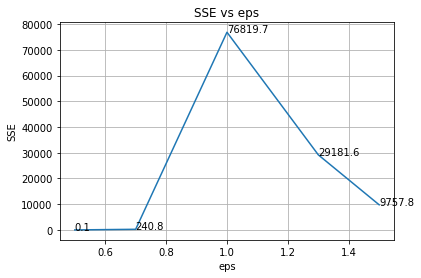

In [119]:
fig, ax = plt.subplots()
ax.plot(eps_data_df.eps, eps_data_df.sse)
ax.set_xlabel("eps")
ax.set_ylabel("SSE")
ax.set_title("SSE vs eps")
for i, txt in eps_data_df.iterrows():
    ax.annotate("{0:.1f}".format(txt['sse']), (txt['eps'],txt['sse']))
plt.grid(True)
plt.show()

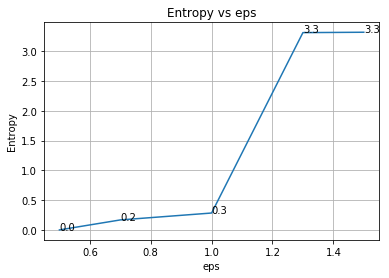

In [121]:
fig, ax = plt.subplots()
ax.plot(eps_data_df.eps, eps_data_df.entropy)
ax.set_xlabel("eps")
ax.set_ylabel("Entropy")
ax.set_title("Entropy vs eps")
for i, txt in eps_data_df.iterrows():
    ax.annotate("{0:.1f}".format(txt['entropy']), (txt['eps'],txt['entropy']))
plt.grid(True)
plt.show()

In [123]:
sample_list = []
min_samples = [10, 15, 20, 25, 40]
for ms in min_samples:
    score = {}
    db = DBSCAN(eps=1.0, min_samples=ms).fit(word_vectorized)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    score['min_sample'] = ms
    score['sse'], score['entropy'] = calculate_sse_entroyp(n_clusters_, labels, word_vectorized)
    
    sample_list.append(score)

In [124]:
sample_list_df = pd.DataFrame(sample_list)

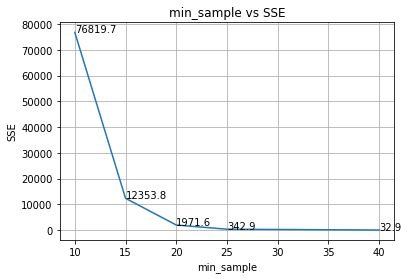

In [126]:
fig, ax = plt.subplots()
ax.plot(sample_list_df.min_sample, sample_list_df.sse)
ax.set_xlabel("min_sample")
ax.set_ylabel("SSE")
ax.set_title("min_sample vs SSE")
for i, txt in sample_list_df.iterrows():
    ax.annotate("{0:.1f}".format(txt['sse']), (txt['min_sample'],txt['sse']))
plt.grid(True)
plt.show()

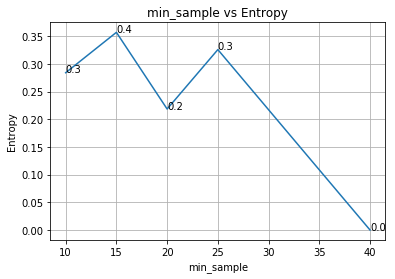

In [127]:
fig, ax = plt.subplots()
ax.plot(sample_list_df.min_sample, sample_list_df.entropy)
ax.set_xlabel("min_sample")
ax.set_ylabel("Entropy")
ax.set_title("min_sample vs Entropy")
for i, txt in sample_list_df.iterrows():
    ax.annotate("{0:.1f}".format(txt['entropy']), (txt['min_sample'],txt['entropy']))
plt.grid(True)
plt.show()